# k-vecinos más cercanos versión 2

In [1]:
import os
import path
import zipfile
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, precision_score, classification_report, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
Path = "/home/michell21/Datasets/" #Puede cambiar de acuerdo al usuario

Instalar las siguientes librerías para leer el archivo

- conda install xlrd
- conda install openpyxl

In [3]:
read = pd.read_excel(Path+'Pozos_Michoacan.xlsx')

In [4]:
pozos = pd.DataFrame(pd.read_excel(Path+'Pozos_Michoacan.xlsx'))

In [5]:
pozos.head()

,#,Título,Latitud,Longitud,Estado,Municipio,RegiónHidrológica,Cuenca,AcuíferoHomologado,Volumen (m3/año),Uso
0,1,837156,"19°58'36.0006""","-101°16'41.0007""",MICHOACÁN DE OCAMPO,HUANDACAREO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,22800.0,AGRICOLA
1,2,836988,"19°59'22.0004""","-101°16'30.0003""",MICHOACÁN DE OCAMPO,HUANDACAREO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,9000.0,AGRICOLA
2,3,836992,"20°02'22.0006""","-101°09'00.0005""",MICHOACÁN DE OCAMPO,CUITZEO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,20020.0,AGRICOLA
3,4,836822,"20°01'50.0005""","-101°09'38.0006""",MICHOACÁN DE OCAMPO,CUITZEO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,6000.0,AGRICOLA
4,5,835739,"19°49'11.0005""","-101°08'37.0006""",MICHOACÁN DE OCAMPO,TARÍMBARO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,30000.0,SERVICIOS


In [28]:
pozos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1363 entries, 0 to 1362
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   #                   1363 non-null   int64  
 1   Título              1363 non-null   object 
 2   Latitud             1363 non-null   object 
 3   Longitud            1363 non-null   object 
 4   Estado              1363 non-null   object 
 5   Municipio           1363 non-null   object 
 6   RegiónHidrológica   1363 non-null   object 
 7   Cuenca              1363 non-null   int64  
 8   AcuíferoHomologado  1363 non-null   object 
 9   Volumen (m3/año)    1363 non-null   float64
 10  Uso                 1363 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 117.3+ KB


In [5]:
pozos.describe()

,#,Cuenca,Volumen (m3/año)
count,1363.00000,1363.000000,1.363000e+03
mean,682.00000,28.546588,1.558366e+05
std,393.60852,67.485278,3.884465e+05
min,1.00000,0.000000,0.000000e+00
25%,341.50000,0.000000,1.500000e+04
50%,682.00000,0.000000,4.668000e+04
75%,1022.50000,0.000000,1.621800e+05
max,1363.00000,188.000000,1.103760e+07


Como no hay registros vacios, se procede a trabajar con los datos. Lo primero será borrar la columna # 

# Visualización de Datos

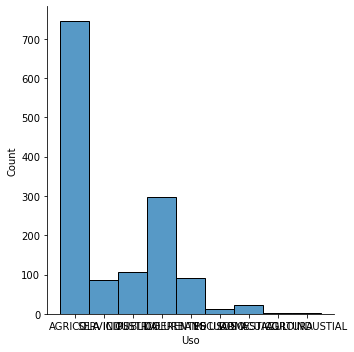

In [6]:
sns.displot(pozos['Uso'], palette="rocket")

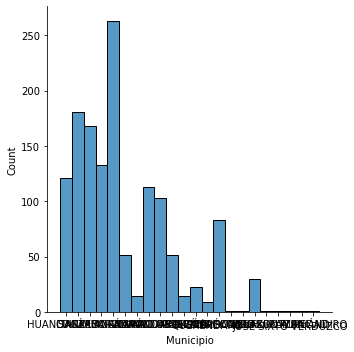

In [7]:
sns.displot(pozos['Municipio'], palette="rocket")

In [5]:
pozos.drop(['#', 'Estado', "Título"], axis = 1, inplace = True) #Eliminamos estos dos ya que no aportan información

In [6]:
def grad2float(datos, id1,id2):
    characters = '°\'"'
    lista = []
    for i in datos:
        i = ''.join( x for x in i if x not in characters)
        if i[0] == '-':
            a = -1*(3600*float(i[1:id1]) + 60*float(i[id1:id2]) + float(i[id2:])) #Para longitud
        else:
            a = 3600*float(i[:id1]) + 60*float(i[id1:id2]) + float(i[id2:])
        #a = 3600*float(i[:4]) + 60*float(i[4:6]) + float(i[6:]) #Para latitud
        lista.append(float(a))
    return lista

In [7]:
pozos['Latitud'] = grad2float(pozos['Latitud'], 2, 4)
pozos['Longitud'] = grad2float(pozos['Longitud'], 4, 6)

In [8]:
pozos['Uso'].value_counts()  #No unir a Diferentes usos

AGRICOLA           745
PUBLICO URBANO     296
INDUSTRIAL         107
DIFERENTES USOS     91
SERVICIOS           87
DOMESTICO           23
PECUARIO            11
ACUACULTURA          2
AGROINDUSTIAL        1
Name: Uso, dtype: int64

In [84]:
pozos['AcuíferoHomologado'].value_counts()  #Eliminar

1602 - MORELIA-QUERENDARO       1335
1610 - CIUDAD HIDALGO-TUXPAN      28
Name: AcuíferoHomologado, dtype: int64

In [9]:
pozos[pozos['Uso'] == 'ACUACULTURA']

,Latitud,Longitud,Municipio,RegiónHidrológica,Cuenca,AcuíferoHomologado,Volumen (m3/año),Uso
280,71665.0,-363020.0,ZINAPÉCUARO,LERMA-SANTIAGO,0,1602 - MORELIA-QUERENDARO,30000.0,ACUACULTURA
1302,71663.0,-364157.0,CUITZEO,LERMA-SANTIAGO,0,1602 - MORELIA-QUERENDARO,15000.0,ACUACULTURA


In [10]:
#Unimos los usos menos comunes en una nueva etiqueta llamada "Otros Usos"
pozos[pozos['Uso'] == 'AGROINDUSTIAL']

,Latitud,Longitud,Municipio,RegiónHidrológica,Cuenca,AcuíferoHomologado,Volumen (m3/año),Uso
941,72255.0,-364034.0,SANTA ANA MAYA,LERMA-SANTIAGO,0,1602 - MORELIA-QUERENDARO,40000.0,AGROINDUSTIAL


In [8]:
#Reemplazar el Uso con "OTROS USOS"
#pozos['Uso'].replace(['ACUACULTURA', 'AGROINDUSTIAL'], 'DIFERENTES USOS', inplace = True)
pozos['AcuíferoHomologado'].replace('1602  - MORELIA-QUERENDARO', '1602 - MORELIA-QUERENDARO', inplace = True)
#pozos['Municipio'].replace(['PURUÁNDIRO', 'TZINTZUNTZAN', 'LA PIEDAD', 'LAGUNILLAS', 'JOSÉ SIXTO VERDUZCO', 
                            #'ARIO', 'HUIRAMBA'], 'VARIOS', inplace = True)

In [58]:
#Unir los registros con AcuíferoHomologado = '1602 - MORELIA-QUERENDARO' y '1602  - MORELIA-QUERENDARO'
#pozos['AcuíferoHomologado'] = pozos['AcuíferoHomologado'].map({'1602  - MORELIA-QUERENDARO': '1602 - MORELIA-QUERENDARO', 
                                                              #'1610 - CIUDAD HIDALGO-TUXPAN': '1610 - CIUDAD HIDALGO-TUXPAN',
                                                              #'1602 - MORELIA-QUERENDARO': '1602 - MORELIA-QUERENDARO'},na_action=None)#'1602 - MORELIA-QUERENDARO' #1138+197

In [13]:
pozos.describe()

,Latitud,Longitud,Cuenca,Volumen (m3/año)
count,1363.000000,1363.000000,1363.000000,1.363000e+03
mean,71490.946855,-364096.132121,28.546588,1.558366e+05
std,645.397221,721.149748,67.485278,3.884465e+05
min,68005.000000,-371361.000000,0.000000,0.000000e+00
25%,71118.004800,-364411.500000,0.000000,1.500000e+04
50%,71468.000000,-364145.000000,0.000000,4.668000e+04
75%,71938.250000,-363778.000000,0.000000,1.621800e+05
max,79260.000000,-362170.000000,188.000000,1.103760e+07


In [9]:
pozos.head()

,Latitud,Longitud,Municipio,RegiónHidrológica,Cuenca,AcuíferoHomologado,Volumen (m3/año),Uso
0,71916.0006,-364601.0007,HUANDACAREO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,22800.0,AGRICOLA
1,71962.0004,-364590.0003,HUANDACAREO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,9000.0,AGRICOLA
2,72142.0006,-364140.0005,CUITZEO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,20020.0,AGRICOLA
3,72110.0005,-364178.0006,CUITZEO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,6000.0,AGRICOLA
4,71351.0005,-364117.0006,TARÍMBARO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,30000.0,SERVICIOS


# Dividir los datos en $X$ y $y$

In [11]:
X = pozos.iloc[:,:-1]
y = pozos['Uso']
#y = pozos[['Uso', 'Uso Ponderado']]

In [12]:
X.head()

,Latitud,Longitud,Municipio,RegiónHidrológica,Cuenca,AcuíferoHomologado,Volumen (m3/año)
0,71916.0006,-364601.0007,HUANDACAREO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,22800.0
1,71962.0004,-364590.0003,HUANDACAREO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,9000.0
2,72142.0006,-364140.0005,CUITZEO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,20020.0
3,72110.0005,-364178.0006,CUITZEO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,6000.0
4,71351.0005,-364117.0006,TARÍMBARO,LERMA-SANTIAGO,188,1602 - MORELIA-QUERENDARO,30000.0


In [15]:
y.head() 

0     AGRICOLA
1     AGRICOLA
2     AGRICOLA
3     AGRICOLA
4    SERVICIOS
Name: Uso, dtype: object

## Codificar los datos categoricos y Escalar los datos numericos en X

In [12]:
def codificar(data):
    cat = []
    num = []
    for i in data.columns:
        if data[i].dtypes == 'object':
            cat.append(i)
        elif data[i].dtypes == 'float64' or 'int64':
            num.append(i)
    scaler = MinMaxScaler() 
    scaled_values = scaler.fit_transform(data[num])
    data[num] = scaled_values
    code = LabelEncoder()
    data[cat] = data[cat].apply(code.fit_transform)
    print('num', num)
    print('cat',cat)
    return data

In [13]:
x_cod = X.copy()
X_cod = codificar(X)

num ['Latitud', 'Longitud', 'Cuenca', 'Volumen (m3/año)']
cat ['Municipio', 'RegiónHidrológica', 'AcuíferoHomologado']


In [18]:
X_cod.head()

,Latitud,Longitud,Municipio,RegiónHidrológica,Cuenca,AcuíferoHomologado,Volumen (m3/año)
0,0.347490,0.735502,7,1,1.0,0,0.002066
1,0.351577,0.736699,7,1,1.0,0,0.000815
2,0.367570,0.785660,5,1,1.0,0,0.001814
3,0.364727,0.781525,5,1,1.0,0,0.000544
4,0.297290,0.788162,18,1,1.0,0,0.002718


# Dividir los datos en Train y Test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_cod, y, test_size = 0.3, shuffle=True)

# Construir modelo

In [15]:
#n_neighbors = 

knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

Precisión =  0.6625916870415648
                 precision    recall  f1-score   support

       AGRICOLA       0.74      0.85      0.79       219
DIFERENTES USOS       0.12      0.07      0.09        29
      DOMESTICO       0.00      0.00      0.00         7
     INDUSTRIAL       0.79      0.81      0.80        32
       PECUARIO       0.50      1.00      0.67         2
 PUBLICO URBANO       0.55      0.52      0.53        89
      SERVICIOS       0.50      0.29      0.37        31

       accuracy                           0.66       409
      macro avg       0.46      0.51      0.46       409
   weighted avg       0.63      0.66      0.64       409



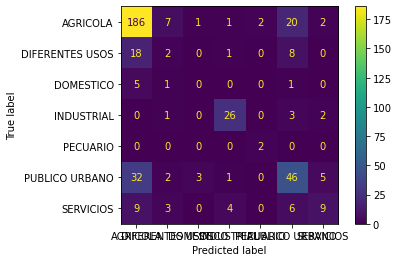

In [16]:
# Predicción

pred = knn.predict(X_test)
y_pred = pd.Series(pred, index=y_test.index)
print('Precisión = ', precision_score(y_test, pred, average='micro'))
print(classification_report(y_test, pred))
plot_confusion_matrix(knn, X_test, y_test)

## Saber cuales fueron las etiquetas que sí acertó

In [89]:
y_test.index

Int64Index([ 420,  771, 1158, 1343,  802, 1071, 1353,  300,  496,  948,
            ...
             336,   56,  514,  123,  129,  792, 1293, 1217,  801,  895],
           dtype='int64', length=409)

In [17]:
def match(y_t, y_p):
    matched = {}
    aux = 0
    for i, j in zip(y_t, y_p):
        if i == j:
            #data.loc[[i, 'Volumen (m3/año)']]
            matched[y_t.index[aux]]= i
        aux+=1
    return matched
aux = match(y_test, y_pred)

In [46]:
pozos.iloc[1116][6]/volumen_total

4.7118406735597736e-06

In [42]:
aux[420]

'AGRICOLA'

## Obtener el volumen total

In [10]:
volumen_total = sum(pozos['Volumen (m3/año)'].values)

In [100]:
def volumen(data, indices, vol):
    vol_pond = {}
    for i in list(indices.keys()):
        v_pond = (data.iloc[i][6])/vol
        vol_pond[i] = indices[i], v_pond
    return vol_pond

In [101]:
volumen_pon = volumen(pozos, aux, volumen_total)

In [80]:
volumen_pon

{420: ('AGRICOLA', 0.000593205496361515),
 1158: ('AGRICOLA', 0.0003220258408819653),
 1343: ('AGRICOLA', 0.0007061970194779941),
 802: ('INDUSTRIAL', 0.0024745143562508913),
 1071: ('AGRICOLA', 0.0018266962903830779),
 1353: ('AGRICOLA', 0.00032955860908973056),
 300: ('INDUSTRIAL', 0.004742819182814208),
 496: ('AGRICOLA', 1.4123940389559881e-05),
 64: ('AGRICOLA', 0.0002462273607913273),
 1116: ('PUBLICO URBANO', 4.7118406735597736e-06),
 722: ('PUBLICO URBANO', 2.16520006171953e-05),
 495: ('AGRICOLA', 2.8247880779119763e-05),
 959: ('AGRICOLA', 7.06197019477994e-05),
 798: ('INDUSTRIAL', 0.0053614477718769305),
 872: ('PUBLICO URBANO', 0.001506553641553054),
 502: ('AGRICOLA', 2.8247880779119763e-05),
 837: ('PUBLICO URBANO', 0.00866268343893006),
 252: ('AGRICOLA', 0.0001412394038955988),
 1182: ('AGRICOLA', 4.237182116867964e-05),
 908: ('AGRICOLA', 0.00019773516545383834),
 702: ('PUBLICO URBANO', 0.00025572585194271017),
 758: ('AGRICOLA', 0.0012146588735021497),
 1268: ('PUBL

In [102]:
Vol_df = pd.DataFrame([[key, volumen_pon[key][0], volumen_pon[key][1]] for key in volumen_pon.keys()], columns=['ID', 'Uso', 'Volumen Ponderado'])
Vol_df.head()

,ID,Uso,Volumen Ponderado
0,420,AGRICOLA,0.000593
1,1158,AGRICOLA,0.000322
2,1343,AGRICOLA,0.000706
3,802,INDUSTRIAL,0.002475
4,1071,AGRICOLA,0.001827


In [103]:
Vol_df.groupby('Uso').sum()

,ID,Volumen Ponderado
Uso,,
AGRICOLA,128565,0.114226
DIFERENTES USOS,1050,0.000703
INDUSTRIAL,16713,0.066223
PECUARIO,2549,0.000381
PUBLICO URBANO,34588,0.050656
SERVICIOS,3209,0.002216


In [99]:
Vol_df['Volumen Ponderado'].sum()

23.440535461287702

## Hacer un nuevo modelo con cross validation

In [18]:
knn_aux = KNeighborsClassifier()
cv_scores = cross_val_score(knn_aux, X_cod, y, cv=10)
print(cv_scores)
print("Score promedio", np.mean(cv_scores))

[0.7080292  0.5620438  0.61313869 0.63970588 0.70588235 0.66176471
 0.65441176 0.66176471 0.63970588 0.52205882]
Score promedio 0.6368505796479176


## Usar GridSearchCV para ver el número óptimo de K

In [19]:
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=10)
#fit model to data
knn_gscv.fit(X_train, y_train)

/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [20]:
knn_gscv.best_params_

{'n_neighbors': 19}

In [21]:
knn_gscv.best_score_

0.6646600877192983

Usar 

Precisión =  0.6356968215158925
                 precision    recall  f1-score   support

       AGRICOLA       0.72      0.88      0.79       221
DIFERENTES USOS       0.00      0.00      0.00        27
      DOMESTICO       0.00      0.00      0.00         3
     INDUSTRIAL       0.56      0.68      0.61        40
       PECUARIO       0.00      0.00      0.00         3
 PUBLICO URBANO       0.49      0.43      0.46        86
      SERVICIOS       0.13      0.07      0.09        29

       accuracy                           0.64       409
      macro avg       0.27      0.29      0.28       409
   weighted avg       0.56      0.64      0.59       409



/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michell21/anaconda3/envs/practicasML/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

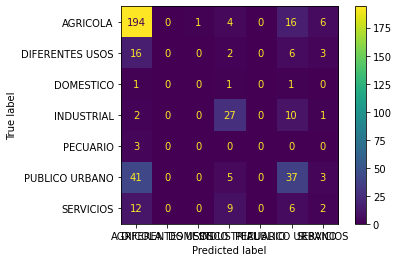

In [70]:
knn_final = knn_gscv.best_estimator_
pred_final = knn_final.predict(X_test)
y_pred_final = pd.Series(pred_final)
print('Precisión = ', precision_score(y_test, y_pred_final, average='micro'))
print(classification_report(y_test, y_pred_final))
plot_confusion_matrix(knn_final, X_test, y_test)

## Graficar los datos

In [25]:
pozos['Uso'].unique()

array(['AGRICOLA', 'SERVICIOS', 'INDUSTRIAL', 'PUBLICO URBANO',
       'DIFERENTES USOS', 'PECUARIO', 'DOMESTICO'], dtype=object)

In [22]:
label = y_test.map({'AGRICOLA': 0, 'SERVICIOS': 1, 'INDUSTRIAL': 2, 'PUBLICO URBANO': 3,
                   'DIFERENTES USOS': 4, 'PECUARIO':5, 'DOMESTICO': 6},na_action=None)

In [23]:
label_p = y_pred.map({'AGRICOLA': 0, 'SERVICIOS': 1, 'INDUSTRIAL': 2, 'PUBLICO URBANO': 3,
                   'DIFERENTES USOS': 4, 'PECUARIO':5, 'DOMESTICO': 6},na_action=None)

In [24]:
def grafica(data):
    for i in range(10):
        plt.scatter(x=data[data==i].index, y=data[data==i], cmap='Sequential')
    return plt.show()

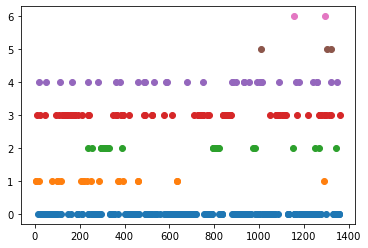

In [25]:
grafica(label) #original

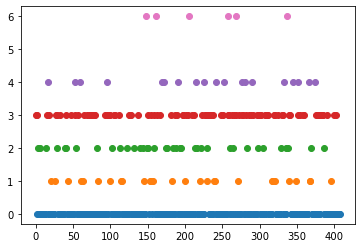

In [26]:
grafica(label_p) #Primera prediccion k=3

# Encontrar el valor de k

([<matplotlib.axis.YTick at 0x7fa2de68e8e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

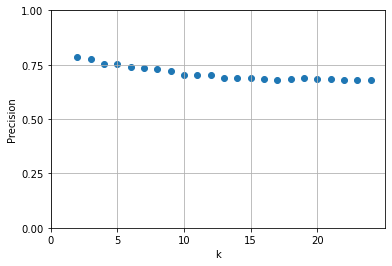

In [41]:
#No usar test. Se sobreajusta

k_range = range(2, 25)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    pred1=knn.predict(X_train)
    scores.append(f1_score(y_train, pred1, average='micro'))
#plt.figure()
plt.scatter(k_range, scores)
plt.xlabel('k')
plt.ylabel('Precision')
plt.grid()
plt.xticks([0,5,10,15,20])
plt.yticks([0, 0.25, 0.5, 0.75, 1])

In [42]:
knn_k = KNeighborsClassifier(n_neighbors=15, weights='distance')
knn_k.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15, weights='distance')

In [43]:
pred_k = knn_k.predict(X_test)
y_pred_k = pd.Series(pred_k)
print('Precisión = ', precision_score(y_test, y_pred_k, average='micro'))

Precisión =  0.6674816625916871


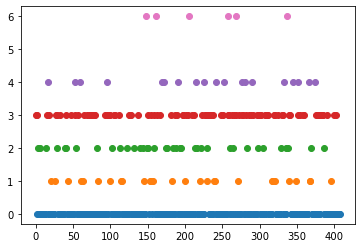

In [31]:
label_final = y_pred.map({'AGRICOLA': 0, 'SERVICIOS': 1, 'INDUSTRIAL': 2, 'PUBLICO URBANO': 3,
                   'DIFERENTES USOS': 4, 'PECUARIO':5, 'DOMESTICO': 6},na_action=None)
grafica(label_p)